In [2]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("model1")

# Create variables
x1 = m.addVar(vtype=GRB.BINARY, name="x1")
x2 = m.addVar(vtype=GRB.BINARY, name="x2")
x3 = m.addVar(vtype=GRB.BINARY, name="x3")

# Set objective

m.setObjective(x1+x2+x3,GRB.MAXIMIZE)


m.addConstr(x1+x2<=1, "c1")
m.addConstr(x1+x3<=1, "c2")
m.addConstr(x2+x3<=1, "c3")


#https://www.gurobi.com/documentation/10.0/refman/cuts.html#parameter:Cuts
m.setParam("Cuts",0)

#https://www.gurobi.com/documentation/10.0/refman/presolve.html
m.setParam("Presolve",0)

#https://www.gurobi.com/documentation/10.0/refman/heuristics.html
m.setParam("Heuristics",0)

#MIP Logging
#https://www.gurobi.com/documentation/10.0/refman/mip_logging.html
    
# Optimize model
m.optimize()






Set parameter Cuts to value 0
Set parameter Presolve to value 0
Set parameter Heuristics to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i9-12900K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 3 rows, 3 columns and 6 nonzeros
Model fingerprint: 0x0647b964
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 3 integer (3 binary)

Root relaxation: objective 1.500000e+00, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.50000    0    3          -    1.50000      -     -    0s
     0     0    1.50

number of customer:  30
number of facilities:  9


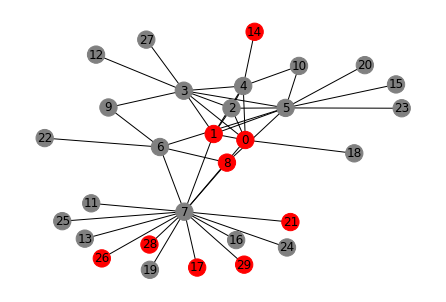

In [267]:
import random
import numpy as np

random.seed(3202)

from itertools import product
from math import sqrt
import gurobipy as gp
from gurobipy import GRB


graph_generator=30
fac_percentage=0.3
max_cost=11

cost_per_mile = 1


import networkx as nx
G = nx.random_internet_as_graph(graph_generator)


customers=list(nx.nodes(G))
num_customers = len(customers)

num_facilities=round(num_customers*fac_percentage)
facilities=random.sample(customers,k=num_facilities)
setup_cost=list(facilities)

for i in range(num_facilities):
    setup_cost[i]=random.randint(1,max_cost)

#print(customers)
#print(facilities)
#print(setup_cost)


print("number of customer: ",num_customers)
print("number of facilities: ",num_facilities)

import matplotlib.pyplot as plt
node_colors = [ "red" if i in facilities else "grey" for i in G.nodes ]

nx.draw(G,with_labels=True, node_color=node_colors )

def compute_distance(loc1, loc2):
    return nx.shortest_path_length(G, source=loc1, target=loc2, weight=None, method='dijkstra')



In [269]:
# Compute key parameters of MIP model formulation
cartesian_prod = list(product(range(num_customers), range(num_facilities)))

# Compute shipping costs

shipping_cost = {(c,f): cost_per_mile*compute_distance(customers[c], facilities[f]) for c, f in cartesian_prod}

m = gp.Model('facility_location')

select = m.addVars(num_facilities, vtype=GRB.BINARY, name='Select')
assign = m.addVars(cartesian_prod, ub=1, vtype=GRB.BINARY, name='Assign')

m.addConstrs((gp.quicksum(assign[(c,f)] for f in range(num_facilities)) == 1 for c in range(num_customers)), name='Demand')

m.setObjective(select.prod(setup_cost)+assign.prod(shipping_cost), GRB.MINIMIZE)

m.addConstrs((assign[(c,f)] <= select[f] for c,f in cartesian_prod), name='Setup2ship')

#m.addConstrs((gp.quicksum(assign[(c,f)] for c in range(num_customers)) <= num_customers*select[f] for f in range(num_facilities)), name='Setup2ship')


m.setParam("Presolve",0)
m.setParam("Heuristics",0)
m.setParam("Cuts",0)

m.optimize()

product_flow = pd.DataFrame(columns=["Customer", "Facility"])

num_opened=0
for b in select: 
 #   print(b)
    if select[b].x > 1e-6: 
        num_opened+=1

print("Number of Opened facilities: ",num_opened)






Set parameter Presolve to value 0
Set parameter Heuristics to value 0
Set parameter Cuts to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i9-12900K, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 300 rows, 279 columns and 810 nonzeros
Model fingerprint: 0x3e103875
Variable types: 0 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Variable types: 0 continuous, 279 integer (279 binary)

Root relaxation: objective 5.200000e+01, 91 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      52.0000000   52.00000  0.00%     -    0s

Expl